# Introduction

This notebook demonstrates the use of the DeForMal package for Demand Load Forecasting.

# Step 1: Import libraries and set country period and some constants

In [13]:
import prepdata
import evaluate as ev
import forecast_models as fm
from forecast_models import NN_Model
import os
import pandas as pd
import numpy as np
import pprint as pp
%matplotlib widget

country_code = 'LU'
country_dir = '../data/Luxembourg/'

loginfile    = '../userdata/Jethro_login.txt'




# Step 2: Get the actual demand load data and the TSO forecast and inspect it

The actual demand data will be used to train our own model, and as a reference for validation, so it is necessary to inspect it for any errors or artefacts. The forecast by the Transmission System Operator (TSO) will be used to measure our own forecast against, so          


For this step to work you need to register at https://transparency.entsoe.eu/ and save the access key in '../userdata/logins.txt'

The data for Luxembourg is already part of the package so you can skip the following code block if you are only interested in this case.

In [2]:
if not os.path.exists(country_dir) :
    os.mkdir(country_dir)  

startdate    = '2020-01-01'
enddate      = '2023-12-31'

filenamebase=f'{country_dir}/{country_code}_{startdate}_to_{enddate}'

        # first get the power data from the ENTSO-E platform    
entsoe_obj = prepdata.EntsoePower( country_code, startdate, enddate, 
                              loginfile=loginfile )    
entsoe_filename = f'{filenamebase}_ENTSOE_power.pkl'    
entsoe_obj.pull_process_save(entsoe_filename)



### Inspect the data:

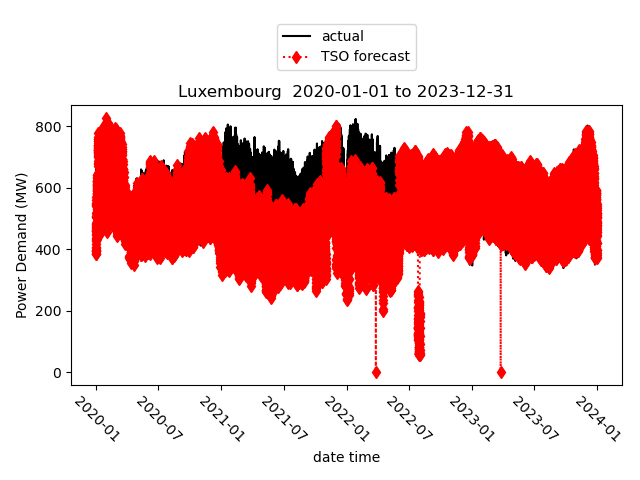

In [2]:

startdate    = '2020-01-01'
enddate      = '2023-12-31'

filenamebase=f'{country_dir}/{country_code}_{startdate}_to_{enddate}'

actual_demand_df     = pd.read_pickle(f'{filenamebase}_ENTSOE_power_actual.pkl')
forecasted_demand_df = pd.read_pickle(f'{filenamebase}_ENTSOE_power_forecast.pkl')

# init an evaluation object with the data
ev_object = ev.Eval(actual_demand_df,forecasted_demand_df , unit='MW',
                           model_name= 'TSO forecast', location= 'Luxembourg')

ev_object.timeseries_plot()




### Selection of validation period

When we hoover our mouse pointer over the figure above, a widget menu will appear on the top left of the figure. Clicking on the cross symbol and using our left and right mouse buttons, we can scroll and zoom through the figure. We can  see that during large periods the forecast provided by the Transmission System Operator (TSO) works fairly well, but there are also periods where there is a large negative bias, and that 2022-02-22 is missing completely. The abrupt appearance and dissapearance of these biases suggest these artefact, rather than inherent flaws of the underlying forecast model(s). They could be caused by subgrid operators or large industrial clients not provided their forecast in time, or technical problems with the data transfer. Additionaly there are artefacts in the spring of 2022 and 2022 due to the daylight savings time shift.

Taking a period where the TSO has substantial artefacts, would make it quite easy to be better with our own method, and would not give a realistic assesment of the quality of the neural network based model. Therefore  we choose 2023 as the validation period, and deselect  the daylight saving time artefact.

### Validation of the TSO forecast

We can now evaluate the performance of the TSO forecast for this period:


                          value unit  \
total nr data pairs        8760    1   
nr of valid actual points  8759    1   
nr of valid model points   8759    1   
nr of valid data pairs     8758    1   

                                                                 description  
total nr data pairs                               total number of data pairs  
nr of valid actual points  Number of points of the actual (i.e. reference...  
nr of valid model points   Number of data points of the model in the inte...  
nr of valid data pairs       number of valid data pairs in the common period  
                    value unit  \
Mean Actual    536.209466   MW   
Stdv. Actual    98.586081   MW   
Mean Model     544.887912   MW   
Stdv. Model     97.846304   MW   
RMSE            19.089012   MW   
MBE              8.678446   MW   
BoSD            -0.739778   MW   
Disp            16.986102   MW   
MAE             14.344352   MW   
Pearson corr.    0.985045    1   
R2_score         0.962508    1

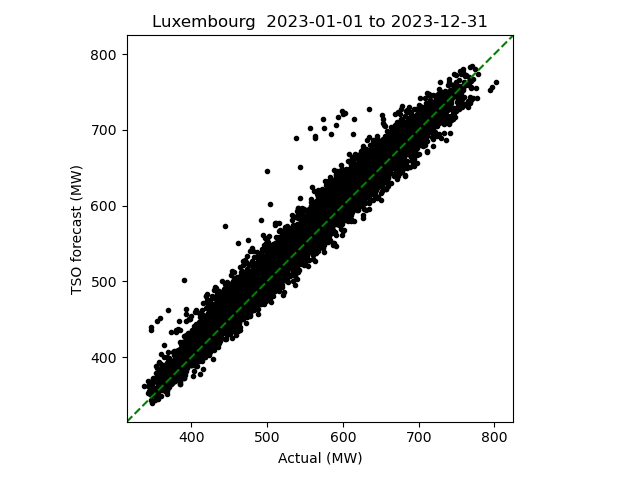

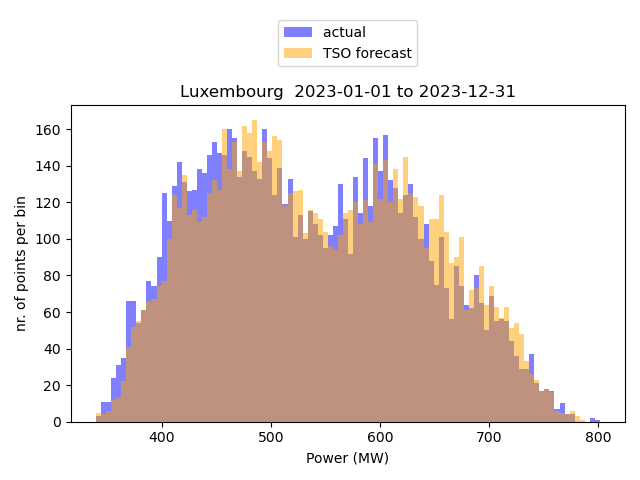

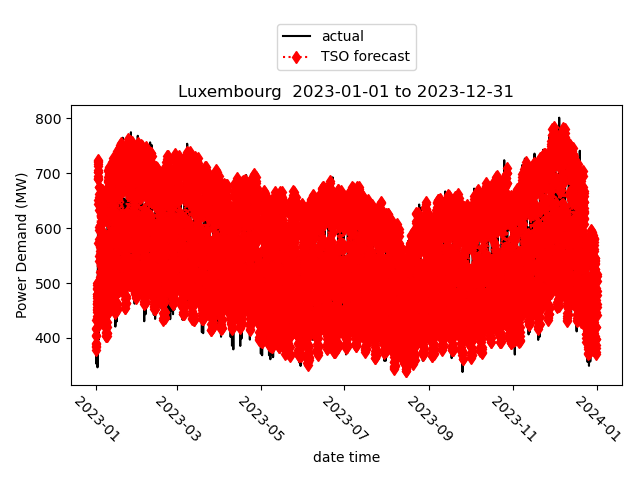

In [15]:
# Find the DST artefacts, and set the values to NaN

DST_artefact_index=forecasted_demand_df[forecasted_demand_df==0].index
actual_demand_df[DST_artefact_index]=np.nan

#seperate the validation period from the rest of the data
splitdate='2023-01-01'

actual_train, actual2eval=prepdata.split_df_on_date(splitdate, actual_demand_df )
forecast_train, forecast2eval=prepdata.split_df_on_date(splitdate, forecasted_demand_df )

ev_object= ev.Eval(actual2eval,forecast2eval, unit='MW', model_name='TSO forecast', location='Luxembourg')

print(ev_object.data_metrics)

ev_object.calc_acc_metrics()

print(ev_object.acc_metrics)

ev_object.scatter_plot()
ev_object.hist_compare_plot()
ev_object.timeseries_plot()



## Step 3: Get and prepare the data for the NN model

For this step to work you need to register at https://transparency.entsoe.eu/ and save the access key in '../userdata/logins.txt'

The data for Luxembourg is already part of the package so you can skip the following code block if you are only interested in this case.

The length of the training data should be short enough, such that long term trends are not missed, but long enough to train the network 

In [23]:
startdate    = '2021-01-01'
enddate      = '2023-12-31'

if not os.path.exists(country_dir) :
    os.mkdir(country_dir)  
        
prepdata.prep_all_data(country_code, startdate, enddate, 
            resultdir=country_dir, loginfile=loginfile )  

## Step 4: First simple NN model

We can now try our hand at the first simple NN model. We only use the time as a single variable

i:  0
Epoch 1/2000
8/8 - 1s - 98ms/step - loss: 0.3651 - val_loss: 0.2808
Epoch 2/2000
8/8 - 0s - 8ms/step - loss: 0.3649 - val_loss: 0.2797
Epoch 3/2000
8/8 - 0s - 8ms/step - loss: 0.3631 - val_loss: 0.2787
Epoch 4/2000
8/8 - 0s - 8ms/step - loss: 0.3620 - val_loss: 0.2776
Epoch 5/2000
8/8 - 0s - 8ms/step - loss: 0.3605 - val_loss: 0.2765
Epoch 6/2000
8/8 - 0s - 8ms/step - loss: 0.3588 - val_loss: 0.2754
Epoch 7/2000
8/8 - 0s - 8ms/step - loss: 0.3587 - val_loss: 0.2744
Epoch 8/2000
8/8 - 0s - 8ms/step - loss: 0.3563 - val_loss: 0.2733
Epoch 9/2000
8/8 - 0s - 8ms/step - loss: 0.3548 - val_loss: 0.2722
Epoch 10/2000
8/8 - 0s - 8ms/step - loss: 0.3553 - val_loss: 0.2712
Epoch 11/2000
8/8 - 0s - 8ms/step - loss: 0.3528 - val_loss: 0.2701
Epoch 12/2000
8/8 - 0s - 8ms/step - loss: 0.3533 - val_loss: 0.2691
Epoch 13/2000
8/8 - 0s - 8ms/step - loss: 0.3504 - val_loss: 0.2680
Epoch 14/2000
8/8 - 0s - 8ms/step - loss: 0.3501 - val_loss: 0.2670
Epoch 15/2000
8/8 - 0s - 8ms/step - loss: 0.3499 -

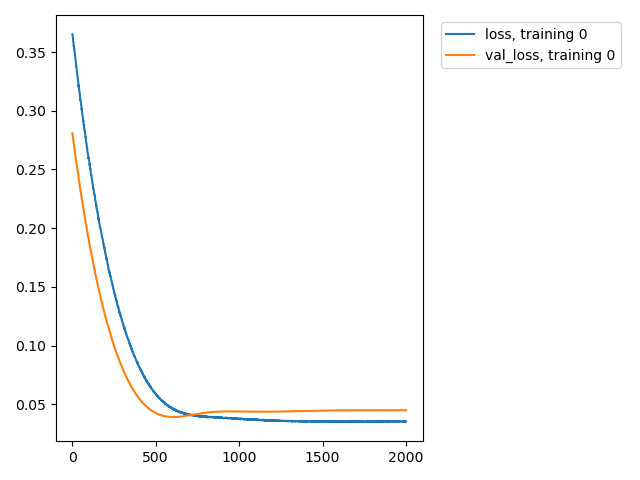

In [26]:

#load the data for the NN model

startdate    = '2021-01-01'
enddate      = '2023-12-31'

filenamebase=f'{country_dir}/{country_code}_{startdate}_to_{enddate}'

actual_demand_df     = pd.read_pickle(f'{filenamebase}_ENTSOE_power_actual.pkl')
forecasted_demand_df = pd.read_pickle(f'{filenamebase}_ENTSOE_power_forecast.pkl')

actual_train, actual2eval=prepdata.split_df_on_date(splitdate, actual_demand_df )
forecast_train, forecast2eval=prepdata.split_df_on_date(splitdate, forecasted_demand_df )

#load the hour as single variable
hour_as_var_df = pd.read_pickle(f'{filenamebase}_hour_as_variable.pkl')
hour_as_var_train, hour_as_var_2eval  = prepdata.split_df_on_date(splitdate,hour_as_var_df )


#define the model 
firstmodel = NN_Model(hour_as_var_df.columns, hidden_nodes=12, hidden_layers=1 )

firstmodel.train_model(hour_as_var_train, actual_train, hour_as_var_2eval,actual2eval,
                   learning_rate=0.00001,verbose=2,epochs=1000, batch_size=100*24)

firstmodel.plot_history()




Let's look at the results:

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


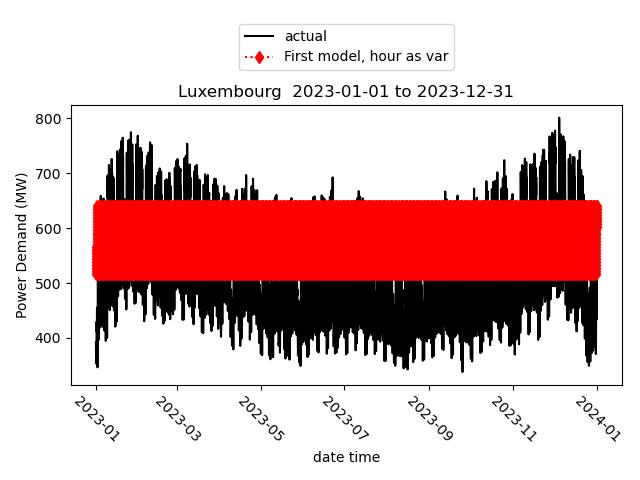

In [27]:
#apply the model to the validation period
P_model1=firstmodel.apply(hour_as_var_2eval)

#create an evaluation object and plot the timeseries
ev_object= ev.Eval(actual2eval,P_model1, unit='MW', model_name='First model, hour as var', location='Luxembourg')
ev_object.timeseries_plot()

Since the input is only the hour of the day, the result will be the same for every day, 
Zooming into the figure we can see this is not working very well, the neural network approximates the curve as a straight line. Let's see if we can do better if we treat the hours as categories, i.e. each hour, minus one,  gets their own column in the input data and has a value of zero or one. 

i:  0
Epoch 1/2000
8/8 - 1s - 101ms/step - loss: 0.5049 - val_loss: 0.4110
Epoch 2/2000
8/8 - 0s - 8ms/step - loss: 0.4979 - val_loss: 0.4034
Epoch 3/2000
8/8 - 0s - 8ms/step - loss: 0.4905 - val_loss: 0.3960
Epoch 4/2000
8/8 - 0s - 9ms/step - loss: 0.4799 - val_loss: 0.3888
Epoch 5/2000
8/8 - 0s - 8ms/step - loss: 0.4701 - val_loss: 0.3816
Epoch 6/2000
8/8 - 0s - 8ms/step - loss: 0.4621 - val_loss: 0.3746
Epoch 7/2000
8/8 - 0s - 9ms/step - loss: 0.4554 - val_loss: 0.3678
Epoch 8/2000
8/8 - 0s - 8ms/step - loss: 0.4482 - val_loss: 0.3611
Epoch 9/2000
8/8 - 0s - 10ms/step - loss: 0.4402 - val_loss: 0.3545
Epoch 10/2000
8/8 - 0s - 9ms/step - loss: 0.4299 - val_loss: 0.3481
Epoch 11/2000
8/8 - 0s - 8ms/step - loss: 0.4232 - val_loss: 0.3418
Epoch 12/2000
8/8 - 0s - 8ms/step - loss: 0.4168 - val_loss: 0.3357
Epoch 13/2000
8/8 - 0s - 8ms/step - loss: 0.4113 - val_loss: 0.3297
Epoch 14/2000
8/8 - 0s - 8ms/step - loss: 0.4034 - val_loss: 0.3237
Epoch 15/2000
8/8 - 0s - 8ms/step - loss: 0.3956

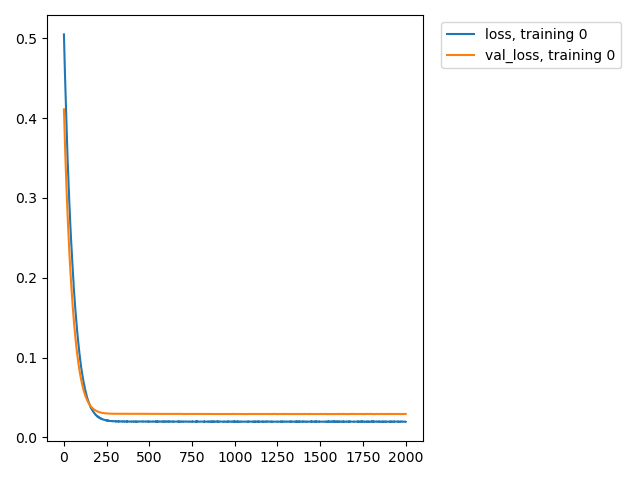

In [29]:
#load the data and split
hour_as_cat_df = pd.read_pickle(f'{filenamebase}_hour_as_category.pkl')
hour_as_cat_train, hour_as_cat_2eval  = prepdata.split_df_on_date(splitdate,hour_as_cat_df )

#load the hour as single variable
hour_as_var_df = pd.read_pickle(f'{filenamebase}_hour_as_variable.pkl')
hour_as_var_train, hour_as_var_2eval  = prepdata.split_df_on_date(splitdate,hour_as_var_df )


#define the model 
model2 = NN_Model(hour_as_cat_df.columns, hidden_nodes=12, hidden_layers=1 )

model2.train_model(hour_as_cat_train, actual_train, hour_as_cat_2eval,actual2eval,
                   learning_rate=0.0001,verbose=2,epochs=1000, batch_size=100*24)

model2.plot_history()




274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step


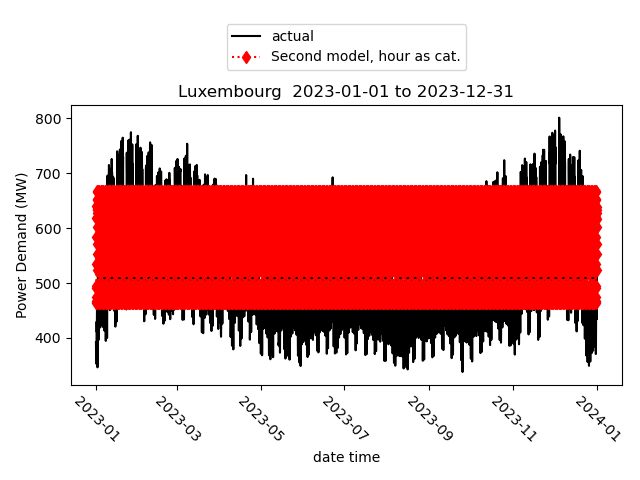

In [31]:
#apply the model to the validation period
P_model2=model2.apply(hour_as_cat_2eval)

#create an evaluation object and plot the timeseries
ev_object= ev.Eval(actual2eval,P_model2, unit='MW', model_name='Second model, hour as cat.', location='Luxembourg')
ev_object.timeseries_plot()

# Step 5: Add calendar variables to the model

## load the data for the calendar variables, and combine them into one dataframe:

In [34]:
#daylight savingstime with a flag for the two days after the switch
DST_df = pd.read_pickle(f'{filenamebase}_daylight_savings_time_flags_lag_2.pkl')

#typedays, assuming that Tuesday till thursday behave the same
typedays_df = pd.read_pickle(f'{filenamebase}_combined_weekday_as_typeday.pkl')

#holidays, only differentiate between public, bank and school holidays
holiday_df = pd.read_pickle(f'{filenamebase}_holidays_by_type.pkl')

#bridgedays, treat the period between christmas and new year also as bridgedays:
bridgeday_df = pd.read_pickle(f'{filenamebase}_bridgedays_incl_yearend.pkl')

x_data = prepdata.combines_dfs(hour_as_cat_df, DST_df,typedays_df,holiday_df, bridgeday_df )

#split the x_data in training and evaluation data
x_data_train, x_data_2eval  = prepdata.split_df_on_date(splitdate,x_data )

Now we can define our new model, train it and validate it

i:  0
Epoch 1/1000
8/8 - 1s - 111ms/step - loss: 0.7979 - val_loss: 0.6773
Epoch 2/1000
8/8 - 0s - 8ms/step - loss: 0.7725 - val_loss: 0.6577
Epoch 3/1000
8/8 - 0s - 10ms/step - loss: 0.7449 - val_loss: 0.6389
Epoch 4/1000
8/8 - 0s - 9ms/step - loss: 0.7197 - val_loss: 0.6211
Epoch 5/1000
8/8 - 0s - 10ms/step - loss: 0.6994 - val_loss: 0.6042
Epoch 6/1000
8/8 - 0s - 8ms/step - loss: 0.6793 - val_loss: 0.5880
Epoch 7/1000
8/8 - 0s - 9ms/step - loss: 0.6640 - val_loss: 0.5726
Epoch 8/1000
8/8 - 0s - 8ms/step - loss: 0.6468 - val_loss: 0.5579
Epoch 9/1000
8/8 - 0s - 12ms/step - loss: 0.6277 - val_loss: 0.5437
Epoch 10/1000
8/8 - 0s - 8ms/step - loss: 0.6099 - val_loss: 0.5300
Epoch 11/1000
8/8 - 0s - 8ms/step - loss: 0.5954 - val_loss: 0.5168
Epoch 12/1000
8/8 - 0s - 8ms/step - loss: 0.5794 - val_loss: 0.5040
Epoch 13/1000
8/8 - 0s - 8ms/step - loss: 0.5629 - val_loss: 0.4916
Epoch 14/1000
8/8 - 0s - 8ms/step - loss: 0.5472 - val_loss: 0.4795
Epoch 15/1000
8/8 - 0s - 8ms/step - loss: 0.53

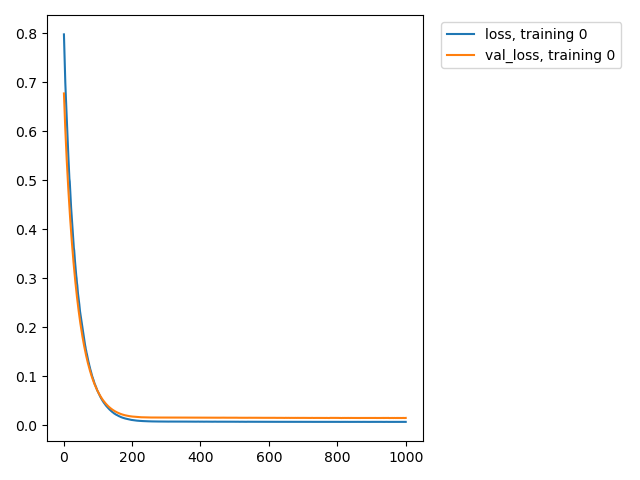

In [36]:
model3 = NN_Model(x_data.columns, hidden_nodes='mean_in_out', hidden_layers=1 )

model3.train_model(x_data_train, actual_train, x_data_2eval,actual2eval,
                   learning_rate=0.0001,verbose=2,epochs=1000, batch_size=100*24)

model3.plot_history()

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


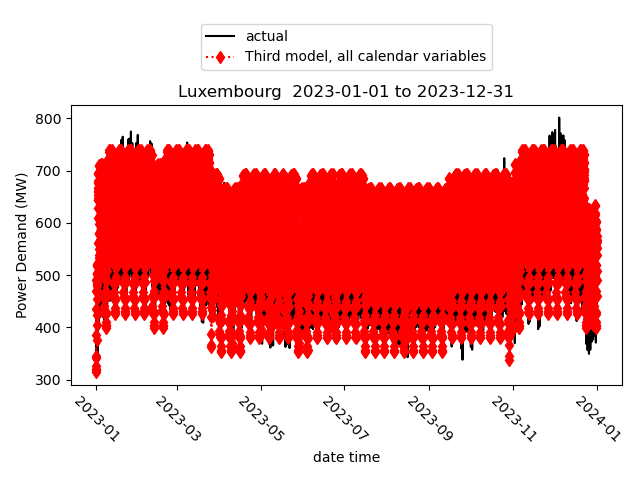

In [37]:
#apply the model to the validation period
P_model3=model3.apply(x_data_2eval)

#create an evaluation object and plot the timeseries
ev_object= ev.Eval(actual2eval,P_model3, unit='MW', model_name='Third model, all calendar variables', location='Luxembourg')
ev_object.timeseries_plot()

This already looks much better, but there are still substantial differences. And the seasonal pattern is not matched very well, so let's introduce weather.

# Step 6: Add weather data